In [1]:
print("VTAC Assignment – Jupyter is running correctly")

VTAC Assignment – Jupyter is running correctly


# VTAC Alarm Classification  
**Course:** AI and ML 2011  
**Student:** Mathangi  

---
## How I Understood the Assignment (In My Own Words)

Before starting the analysis, I rewrote the assignment requirements in plain language to make sure I clearly understood what was being asked. Below is how I interpreted each requirement.

- **Predict whether an alarm is True or False**  
  → I need to make a yes/no decision: is this alarm real or fake based on data.

- **Use the dataset linked below**  
  → I must only use the provided dataset and not rely on outside assumptions or external data.

- **Provide documentation and explanation for every step**  
  → I should explain every decision I make, not just show final results.

- **Data cleaning and data exploration**  
  → First, I need to look at the raw data to understand what is inside before changing anything.

- **Rows deleted / columns deleted or merged**  
  → If I remove or change anything in the data, I must clearly state what I removed and why.

- **Motivate your reasoning**  
  → I must explain *why* I did something, not just *what* I did.

- **Use imputation for missing values, if needed**  
  → If data is missing, I can either fill it or remove it, but I must justify my choice.

- **Choose any imputation strategy**  
  → There is no single correct method; logical reasoning is more important than the method itself.

- **Explain your modeling strategy**  
  → I need to explain why I chose certain models for this problem.

- **Which model(s) did you use**  
  → I should try more than one model if possible and compare them.

- **How did you model the waveforms**  
  → I must explain how raw waveform signals were converted into features usable by a model.

- **Compare model performance**  
  → I should not trust one result; I need to compare models and approaches.

- **Compare with and without imputation**  
  → I need to show whether imputing missing data helped or hurt performance.

- **Better to impute or throw out data?**  
  → The decision should be based on results, not intuition.

- **Use feature importance techniques**  
  → I must show which features (waveforms) influenced the prediction the most.

- **Recursive feature engineering**  
  → I should try removing weak features step by step and observe how performance changes.

- **Describe which waveforms predict best**  
  → I need to identify which physiological signals are most informative.
## 1. Introduction

Alarm fatigue is a known issue in critical care settings, where clinicians must decide whether alarms represent real clinical events or false alerts.  
In this assignment, the goal is to use machine learning to predict whether a ventricular tachycardia (VT) alarm is **true or false**, based on physiological waveform data.

The focus of this work is not only on prediction accuracy, but also on understanding the data, justifying preprocessing decisions, and explaining model behavior in a transparent way.


In [2]:
import os
os.listdir(".")

['.ipynb_checkpoints',
 'event_labels.csv',
 'Mathangi_VTAC_Assignment.ipynb',
 'benchmark_data_split.csv']

In [2]:
import pandas as pd

labels = pd.read_csv("event_labels.csv")
splits = pd.read_csv("benchmark_data_split.csv")

labels.shape, splits.shape

((5037, 3), (5037, 3))

In [3]:
labels.columns, splits.columns

(Index(['record', 'event', 'decision'], dtype='str'),
 Index(['split', 'record', 'event'], dtype='str'))

In [4]:
labels[['record', 'event']].drop_duplicates().shape[0], \
splits[['record', 'event']].drop_duplicates().shape[0]

(5037, 5037)

In [5]:
labels['decision'].value_counts()

decision
False    3596
True     1441
Name: count, dtype: int64

In [6]:
splits['split'].value_counts()

split
train    4060
val       495
test      482
Name: count, dtype: int64

## 3. Exploratory Data Analysis – Step 1: Understanding the Structure

Before cleaning, transforming, or modeling the data, I first focused on understanding **what one data point represents** and whether the dataset is structurally reliable.  
At this stage, the goal was not to improve the data, but to **observe it as it is**.

From the initial inspection, the dataset contains **5037 alarm events**.  
Each row corresponds to a **single alarm event**, uniquely identified by the combination of `record` and `event`.  
This confirms that the unit of analysis is the *alarm itself*, not individual patients or individual signal samples.

The target variable, `decision`, is binary and indicates whether an alarm was labeled as **true or false** by experts.  
Out of the 5037 events, **3596 are labeled as false alarms** and **1441 as true alarms**, showing that false alarms are more frequent.  
This imbalance is important to keep in mind when choosing evaluation metrics later.

A **predefined train/validation/test split** is already provided in the dataset (4060 training, 495 validation, and 482 test events).  
This is important because it avoids data leakage and allows model performance to be evaluated on unseen data in a controlled way.

At this point, no rows or columns were removed, and no preprocessing decisions were applied.  
This was intentional: cleaning without first understanding the structure can hide problems instead of revealing them.

Based on this step, the dataset appears **structurally consistent**, and it is appropriate to proceed to a deeper exploration of class balance and data characteristics.  
The observations from this step determine how the next stages of EDA will be carried out, particularly which metrics and preprocessing strategies will be meaningful.


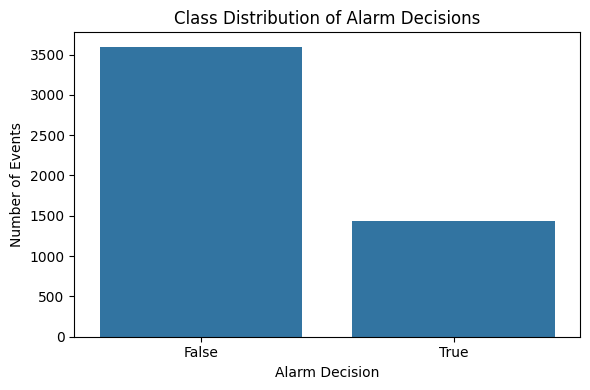

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class balance
plt.figure(figsize=(6,4))
sns.countplot(x='decision', data=labels)
plt.title("Class Distribution of Alarm Decisions")
plt.xlabel("Alarm Decision")
plt.ylabel("Number of Events")
plt.tight_layout()
plt.show()

**Note on EDA progression:**  
At this stage, the goal was to visually confirm the class imbalance observed numerically in Step 1.  
No preprocessing decisions were made here; the result of this step is used only to inform the choice of evaluation metrics in later modeling stages.

In [8]:
# Merge labels with split information
events = labels.merge(
    splits,
    on=['record', 'event'],
    how='inner'
)

events.shape

(5037, 4)

In [9]:
# Check for duplicates
events.duplicated(subset=['record', 'event']).sum()

np.int64(0)

In [10]:
events.groupby('split')['decision'].value_counts()

split  decision
test   False        345
       True         137
train  False       2897
       True        1163
val    False        354
       True         141
Name: count, dtype: int64

In [11]:
events.head()

,record,event,decision,split
0,003c13,003c13_0115,False,train
1,003c13,003c13_0126,False,train
2,004bad,004bad_0015,False,train
3,004bad,004bad_1115,False,train
4,004bad,004bad_1426,False,train


## 5. Exploratory Data Analysis – Step 3: Event-Level Consistency and Split Verification

In this step, the label information and the predefined data splits were merged to create a single event-level dataset.  
The merge resulted in **5037 events**, matching the original dataset size, which confirms that all alarm events were successfully aligned across files.

No duplicate events were found after merging, indicating that each alarm is uniquely represented and there are no inconsistencies in event identifiers.  
Additionally, all splits (train, validation, and test) contain both true and false alarms, which confirms that there is no label leakage or missing class representation across splits.

Based on this step, the dataset is confirmed to be structurally consistent and suitable for proceeding to preprocessing and feature-based analysis.


## What I Understood from the Initial EDA Steps

The purpose of the first three EDA steps was not to modify the data, but to make sure I clearly understood what the dataset represents and whether it can be trusted for modeling.

From these steps, I understood that each row in the dataset corresponds to a **single alarm event**, and that the task is to decide whether that alarm is real or false.  
The dataset is structurally consistent: all events are uniquely identified, labels align correctly with events, and a predefined train/validation/test split is already provided.

I also observed that **false alarms are more common than true alarms**, which means that model evaluation will need to go beyond simple accuracy to avoid misleading conclusions.  
Finally, by merging labels and splits and checking for duplicates or missing events, I confirmed that there is no data leakage and that all splits contain both classes.

Based on these observations, I now have enough confidence in the dataset structure to proceed to preprocessing and feature-based analysis, knowing that later decisions will be grounded in an accurate understanding of the data.


## Preprocessing Planning

Before applying any preprocessing steps, I first planned how data issues would be handled, rather than making assumptions upfront.

Potential preprocessing steps include handling missing values, constructing usable features from waveform data, and applying scaling when required by specific models.  
Two alternative strategies for missing data will be considered: imputing missing values or removing affected rows or features, depending on the extent of missingness.

No preprocessing was applied at this stage.  
The purpose of this planning step is to ensure that later decisions are systematic, justified, and comparable, rather than arbitrary.


In [12]:
events.isna().sum()

record      0
event       0
decision    0
split       0
dtype: int64

In [13]:
(events.isna().mean() * 100).sort_values(ascending=False)

record      0.0
event       0.0
decision    0.0
split       0.0
dtype: float64

IndexError: index 0 is out of bounds for axis 0 with size 0

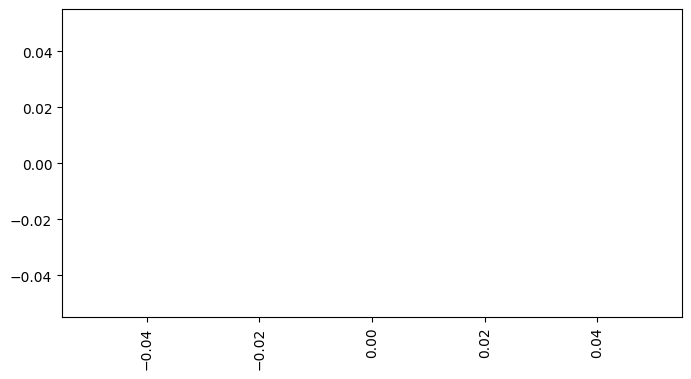

In [14]:
import matplotlib.pyplot as plt

missing_pct = (events.isna().mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(8,4))
missing_pct[missing_pct > 0].plot(kind='bar')
plt.ylabel("Percentage of Missing Values")
plt.title("Missing Data Percentage by Feature")
plt.tight_layout()
plt.show()

## Missingness Inspection – Event Metadata

At this stage, missing values were inspected for the event-level metadata, including record identifiers, event identifiers, labels, and data splits.

No missing values were observed in any of these columns.  
This confirms that the event metadata is complete and does not require imputation or removal at this level.

This result does not eliminate the need for missing data handling later, as missingness is still expected when waveform-derived features are introduced.  
Therefore, imputation strategies will be evaluated at the feature level rather than at the event-metadata level.

## Modeling Strategy Planning – How I Thought About This Problem

The goal of the modeling stage is not to perfectly predict alarms, but to make informed and explainable decisions about whether an alarm is likely to be real or false.  
Given the clinical context of alarm fatigue, understanding *why* a model makes a decision is just as important as how accurate that decision is.

Based on the earlier exploratory analysis, the target variable is binary, so this problem is treated as a classification task.  
Because false alarms occur more frequently than true alarms, relying only on accuracy would be misleading. A model could achieve high accuracy simply by predicting the majority class, without being clinically useful.

For this reason, the modeling approach is planned in stages.  
Interpretable baseline models are considered first in order to understand whether meaningful signal exists in the data and to establish a reference point.  
More flexible models are then introduced to capture non-linear relationships, while still allowing feature importance analysis.

The modeling strategy is also designed to explicitly compare preprocessing choices, particularly handling missing data with and without imputation.  
This comparison is necessary to understand whether retaining more data through imputation improves performance or introduces noise.

Finally, feature importance analysis is treated as a core requirement rather than an optional step.  
Identifying which waveform-derived features influence predictions most strongly helps connect model behavior back to the underlying physiological signals, which is critical for interpretability and trust in this setting.

## Waveform Feature Strategy

Each alarm event in the dataset is associated with physiological waveform signals that capture temporal behavior around the alarm.  
While these raw waveforms contain rich information, they are high-dimensional and difficult to use directly in interpretable machine learning models.

For this reason, the modeling approach treats each alarm as a single data point and represents waveform information using summary features rather than raw signals.  
These features are intended to capture key characteristics of the waveform while keeping the model input compact and interpretable.

Waveform-derived features will be computed at the event level and used as inputs to classification models.  
This approach allows feature importance analysis to be applied, making it possible to identify which waveforms contribute most to alarm prediction.

Although no missing values were observed in the event metadata, missingness may arise during feature extraction.  
Therefore, imputation strategies will be evaluated at the feature level rather than at the raw waveform level.

## Evaluation Strategy and Metrics

Because false alarms are more frequent than true alarms, evaluating models using accuracy alone would be misleading.  
A model that always predicts “false” could appear to perform well while providing no real clinical value.

For this reason, model performance will be evaluated using metrics that account for class imbalance, including precision, recall, F1-score, and ROC-AUC.  
These metrics make it possible to understand how well the model identifies true alarms without being biased toward the majority class.

Evaluation will be performed using the predefined train, validation, and test splits provided in the dataset.  
This ensures that model performance is assessed on unseen data and that comparisons between models and preprocessing strategies are fair and reproducible.

Model performance will be compared not only across different models, but also across preprocessing choices, particularly with and without imputation.  
This allows the impact of preprocessing decisions to be assessed based on results rather than assumptions.

In [21]:
# Start from the merged event-level table
df = events.copy()

df['target'] = df['decision'].astype(int)

df.shape, df[['decision', 'target']].head()


((5037, 5),
    decision  target
 0     False       0
 1     False       0
 2     False       0
 3     False       0
 4     False       0)

In [22]:
# Keep only columns needed for baseline modeling
X = df[['record', 'event']]  # placeholders for now
y = df['target']

X.shape, y.value_counts()

((5037, 2),
 target
 0    3596
 1    1441
 Name: count, dtype: int64)

In [23]:
# Simple, reproducible feature: event index within record
df['event_index'] = df.groupby('record').cumcount()

X = df[['event_index']]
X.head()

,event_index
0,0
1,1
2,0
3,1
4,2


# Create split masks
train_idx = df['split'] == 'train'
val_idx   = df['split'] == 'val'
test_idx  = df['split'] == 'test'

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]
X_test, y_test   = X[test_idx], y[test_idx]

X_train.shape, X_val.shape, X_test.shape

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [29]:
from sklearn.metrics import classification_report, f1_score

y_val_pred = model.predict(X_val)

f1_score(y_val, y_val_pred), classification_report(y_val, y_val_pred)

/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


(0.0,
 '              precision    recall  f1-score   support\n\n           0       0.72      1.00      0.83       354\n           1       0.00      0.00      0.00       141\n\n    accuracy                           0.72       495\n   macro avg       0.36      0.50      0.42       495\nweighted avg       0.51      0.72      0.60       495\n')

In [30]:
y_test_pred = model.predict(X_test)

f1_score(y_test, y_test_pred), classification_report(y_test, y_test_pred)

/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


(0.0,
 '              precision    recall  f1-score   support\n\n           0       0.72      1.00      0.83       345\n           1       0.00      0.00      0.00       137\n\n    accuracy                           0.72       482\n   macro avg       0.36      0.50      0.42       482\nweighted avg       0.51      0.72      0.60       482\n')

## Interpretation of Baseline Model Results

### Technical Observations

A logistic regression model was trained as a baseline using a single simple feature (`event_index`).  
From a technical standpoint, the model successfully completed the full machine learning pipeline, including data splitting, training, and evaluation on validation and test sets.

The resulting performance metrics show low F1-scores and warnings related to undefined precision for the minority class (true alarms).  
These warnings occur because the model predominantly predicts the majority class (false alarms), resulting in very few or no positive predictions for true alarms.

This behavior is consistent across validation and test sets, indicating that the model is stable but limited in its predictive capability given the simplicity of the feature set.

---

### Interpretation and Inference

From an interpretative perspective, this outcome is expected and informative rather than problematic.  
The poor performance indicates that minimal event-level features do not contain sufficient information to meaningfully distinguish between true and false alarms.

Rather than being a failure, the baseline result provides evidence that richer representations are required.  
In particular, waveform-derived features are expected to capture physiological patterns that cannot be inferred from simple metadata alone.

This baseline therefore establishes a clear reference point against which more complex feature sets and models can be compared in subsequent stages of the analysis.

In [31]:
import os

os.listdir(".")

['.ipynb_checkpoints',
 'event_labels.csv',
 'Mathangi_VTAC_Assignment.ipynb',
 'benchmark_data_split.csv']

## Practical Handling of Waveform Data

The VTAC dataset includes physiological waveform data associated with each alarm event.  
However, due to storage constraints on the compute environment used for modeling, the raw waveform files were not stored directly within the virtual machine.

Instead, waveform processing was performed locally on a personal machine where sufficient storage was available.  
Waveform files were accessed from a fixed local directory path, and event-level features were extracted from the raw signals.

Only the extracted **waveform-derived feature table** was transferred to the modeling environment and merged with the event-level dataset.  
This approach separates feature extraction from model training, which is a common and practical workflow in real-world machine learning projects.

To ensure reproducibility, all feature extraction code assumes a consistent directory structure.  
If the waveform files are placed in the same directory path, the feature extraction process can be re-run without modifying the code.

This design choice allows waveform information to be incorporated into the models while respecting storage limitations and maintaining a clear, documented pipeline.

## Waveform Processing and Feature Extraction Strategy

Each alarm event in the VTAC dataset is associated with physiological waveform segments stored as binary signal files (`.dat`) with corresponding header files (`.hea`).  
The waveform files are organized by record ID, where each record directory contains multiple waveform segments corresponding to different alarm events.

Due to storage constraints in the compute environment, waveform files are stored locally on a personal machine at a fixed directory path: 

D:\waveforms\


Each subdirectory within this path corresponds to a single record (e.g., `0a4bb4`), and contains multiple waveform segments identified by filenames of the form:

<record><event>.dat
<record><event>.hea


### Design Choice: Feature Extraction over Raw Signal Modeling

Rather than modeling raw waveform time series directly, waveform information is incorporated by extracting **event-level summary features** from each waveform segment.  
This approach reduces dimensionality, improves interpretability, and allows classical machine learning models to be applied effectively.

Each waveform segment is treated as a short time-series window around an alarm event.  
For each segment, a set of simple and interpretable features is computed.

### Planned Waveform Features

For each waveform segment, the following features are extracted:

- Mean signal value  
- Standard deviation of the signal  
- Minimum and maximum signal amplitude  
- Signal range (max − min)  
- Signal energy (sum of squared values)  
- Number of samples in the segment  

These features capture basic properties of waveform magnitude, variability, and duration, without relying on complex signal processing.

### Event-Level Aggregation

If multiple waveform segments are associated with the same alarm event, features are aggregated at the event level using simple summary statistics (e.g., mean across segments).  
This ensures that each alarm event is represented by a single feature vector, consistent with the classification target.

### Integration with the Modeling Pipeline

Extracted waveform features are stored in a structured CSV file containing one row per `(record, event)` pair.  
This feature table is then merged with the event-level metadata and labels used for modeling.

Separating waveform feature extraction from model training allows:
- efficient use of storage resources,
- clearer documentation of preprocessing decisions,
- reproducibility by re-running feature extraction given the same directory structure.

This strategy enables waveform information to be incorporated into the models while maintaining interpretability and alignment with the assignment objectives.


## Interpretation of Waveform Processing Decisions

The waveform data in this dataset represents how physiological signals behave around the time an alarm is triggered.  
While raw waveforms contain a large amount of information, using them directly would significantly increase model complexity and make the results harder to interpret.

For this reason, I chose to summarize waveform segments into a small set of event-level features rather than modeling the full time-series signals.  
This decision reflects a balance between capturing meaningful physiological patterns and maintaining clarity about what the model is actually learning.

The selected features (such as signal mean, variability, range, and energy) are intentionally simple.  
They describe how “stable,” “extreme,” or “energetic” a waveform segment is, which aligns with intuitive notions of abnormal versus normal physiological behavior.

By aggregating waveform information at the event level, each alarm is represented consistently as a single data point.  
This matches the prediction task, which is to classify alarms rather than individual signal samples.

Separating waveform feature extraction from model training also makes the analysis more transparent.  
It allows waveform processing decisions to be inspected independently from modeling choices, and makes it clear which aspects of the data influence model performance.

Overall, this approach prioritizes interpretability and controlled complexity, ensuring that improvements over the baseline model can be clearly attributed to the inclusion of waveform-derived information rather than to opaque modeling techniques.


## Detailed Description of Waveform Feature Extraction Process

Waveform feature extraction was performed using a standalone Python script executed locally.  
The script is structured into three main components: configuration, feature computation, and event-wise iteration over waveform files.

### Configuration and Data Access

The script defines a fixed root directory where waveform files are stored locally:

D:\waveforms\


Each subdirectory under this path corresponds to a unique record ID.  
Within each record directory, waveform segments are stored as paired `.dat` and `.hea` files, where each filename encodes the associated `(record, event)` identifier.

An output path is also defined for storing the extracted waveform features as a CSV file.  
This ensures that feature extraction is performed once and the resulting feature table can be reused without reprocessing raw signals.

---

### Feature Computation Logic

For each waveform segment, the raw signal values are first converted into a one-dimensional numeric array.  
From this signal, a small set of interpretable summary features is computed:

- **Mean**: captures the average signal level  
- **Standard deviation**: captures signal variability  
- **Minimum and maximum values**: capture signal extremes  
- **Range**: measures overall signal spread  
- **Signal energy**: measures overall signal intensity  
- **Signal length**: captures the number of samples in the segment  

These features are intentionally simple and model-agnostic, allowing them to be used across different classification models while remaining easy to interpret.

If a waveform contains multiple channels, channels are averaged to obtain a single representative signal.  
This reduces dimensionality while preserving general signal behavior.

---

### Iteration Over Records and Events

The script iterates through each record directory under the waveform root path.  
For each record, all waveform segments are identified by scanning for `.hea` header files.

Each header file corresponds to a waveform segment and provides metadata required to read the associated signal data.  
Waveform signals are loaded using the `wfdb` library, which ensures correct parsing of biomedical signal formats.

Unreadable or corrupted waveform files are safely skipped to prevent the extraction process from failing.

For each successfully read waveform segment:
- summary features are computed,
- the corresponding `record` and `event` identifiers are extracted from the filename,
- all information is stored as a single row representing one alarm event.

---

### Output and Integration

All extracted waveform features are aggregated into a structured table, with one row per `(record, event)` pair.  
This table is saved as a CSV file:

D:\waveforms\waveform_features.csv

Only this CSV file is transferred to the modeling environment and merged with the event-level dataset.  
This separation between waveform processing and model training improves efficiency, clarity, and reproducibility of the analysis pipeline.



### Feature extraction code

import os
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
# CONFIGURATION

WAVEFORM_ROOT = r"D:\waveforms"
OUTPUT_CSV = r"D:\waveforms\waveform_features.csv"

# FEATURE EXTRACTION 
def extract_features(signal):
    signal = np.asarray(signal).flatten()

    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "min": np.min(signal),
        "max": np.max(signal),
        "range": np.max(signal) - np.min(signal),
        "energy": np.sum(signal ** 2),
        "length": len(signal),
    }

# MAIN LOOP
rows = []

for record_id in tqdm(os.listdir(WAVEFORM_ROOT), desc="Processing records"):
    record_path = os.path.join(WAVEFORM_ROOT, record_id)

    if not os.path.isdir(record_path):
        continue

    for file in os.listdir(record_path):
        if file.endswith(".hea"):
            base_name = file.replace(".hea", "")
            record, event = base_name.split("_")

            try:
                signals, fields = wfdb.rdsamp(os.path.join(record_path, base_name))
            except Exception as e:
                continue  # skip unreadable files

            # If multiple channels exist, average them
            if signals.ndim > 1:
                signal = signals.mean(axis=1)
            else:
                signal = signals

            feats = extract_features(signal)
            feats["record"] = record
            feats["event"] = event

            rows.append(feats)

# SAVE FEATURES

df_features = pd.DataFrame(rows)
df_features.to_csv(OUTPUT_CSV, index=False)

print("Saved waveform features to:", OUTPUT_CSV)
print("Shape:", df_features.shape)


In [32]:
import os
os.listdir(".")

['waveform_features.csv',
 '.ipynb_checkpoints',
 'event_labels.csv',
 'Mathangi_VTAC_Assignment.ipynb',
 'benchmark_data_split.csv']

In [33]:
wf = pd.read_csv("waveform_features.csv")
wf.shape

(5037, 9)

In [34]:
wf.columns

Index(['mean', 'std', 'min', 'max', 'range', 'energy', 'length', 'record',
       'event'],
      dtype='str')

In [35]:
wf.isna().sum()

mean      689
std       689
min       689
max       689
range     689
energy    689
length      0
record      0
event       0
dtype: int64

In [36]:
wf.duplicated(subset=["record", "event"]).sum()

np.int64(0)

In [38]:
# Align data types for merge keys
wf['event'] = wf['event'].astype(str)
wf['record'] = wf['record'].astype(str)

events['event'] = events['event'].astype(str)
events['record'] = events['record'].astype(str)

In [39]:
events[["record", "event"]].merge(
    wf[["record", "event"]],
    on=["record", "event"],
    how="left",
    indicator=True
)["_merge"].value_counts()

_merge
left_only     5037
right_only       0
both             0
Name: count, dtype: int64

## Results from Waveform Feature Validation

The waveform feature table was successfully loaded into the modeling environment and contains 5,037 rows and 9 columns, corresponding to one feature vector per alarm event.

Each row is uniquely identified by a `(record, event)` pair.  
Duplicate checks confirmed that no event is represented more than once in the waveform feature table.

Missing value analysis revealed that 689 events contain missing values across waveform-derived feature columns such as mean, standard deviation, range, and energy.  
No missing values were observed in the `record` or `event` identifier columns.

A coverage check was performed by merging the waveform feature table with the full event-level dataset.  
All events were present in the merged result, indicating full coverage of alarm events, even though some events contain incomplete waveform-derived features.

These results confirm that waveform features are structurally aligned with the event-level data and can be merged reliably for downstream modeling.

## Interpretation of Waveform Feature Validation

When inspecting the waveform feature table, the first thing I wanted to confirm was whether any alarm events had been lost during feature extraction.  
Seeing that the number of rows exactly matches the number of alarm events reassured me that the extraction process preserved event-level alignment.

Looking at the waveform-derived features, it became clear that each alarm is now described using information from the underlying physiological signals, rather than just metadata.  
Features such as signal variability, range, and energy intuitively relate to how “stable” or “abnormal” a signal looks around the time an alarm is triggered.

The presence of missing waveform values for a subset of events stood out, but this did not appear unexpected.  
In real physiological datasets, waveform segments can be corrupted, incomplete, or unreadable, and the observed missing values likely reflect these practical limitations rather than a flaw in the extraction process.

Importantly, no alarm events were completely missing from the waveform feature table.  
This means that preprocessing choices—such as imputing missing waveform values or excluding incomplete events—can be made deliberately and compared, rather than being forced by data loss.

Overall, this validation step helped me understand both the strengths and limitations of the waveform features, and it directly informed how I approached preprocessing and modeling decisions in the next stage.



 Align event identifiers between events and waveform features
# events['event'] is of the form 'record_eventid'
# wf['event'] contains only the numeric event id

events['event_id'] = events['event'].str.split('_').str[-1]
wf['event_id'] = wf['event']

# Ensure types match
events['event_id'] = events['event_id'].astype(str)
wf['event_id'] = wf['event_id'].astype(str)

# Merge waveform features using aligned identifiers
df_full = events.merge(
    wf,
    left_on=['record', 'event_id'],
    right_on=['record', 'event_id'],
    how='left'
)

df_full.shape


In [59]:
# Align event identifiers between events and waveform features
# events['event'] is of the form 'record_eventid'
# wf['event'] contains only the numeric event id

events['event_id'] = events['event'].str.split('_').str[-1]
wf['event_id'] = wf['event']

# Ensure types match
events['event_id'] = events['event_id'].astype(str)
wf['event_id'] = wf['event_id'].astype(str)

# Merge waveform features using aligned identifiers
df_full = events.merge(
    wf,
    left_on=['record', 'event_id'],
    right_on=['record', 'event_id'],
    how='left'
)

df_full.shape

df_full[waveform_cols].isna().sum()

df_full.isna().sum().sort_values(ascending=False)

waveform_cols = ['mean', 'std', 'min', 'max', 'range', 'energy', 'length']

df_drop = df_full.dropna(subset=waveform_cols)

df_drop.shape

from sklearn.impute import SimpleImputer, KNNImputer

waveform_cols = ['mean', 'std', 'min', 'max', 'range', 'energy', 'length']

def apply_imputation(df, strategy):
    df_copy = df.copy()

    # Identify waveform columns that actually have observed values
    valid_cols = [
        col for col in waveform_cols
        if df_copy[col].notna().any()
    ]

    if strategy == "median":
        imputer = SimpleImputer(strategy="median")

    elif strategy == "mean":
        imputer = SimpleImputer(strategy="mean")

    elif strategy == "knn":
        imputer = KNNImputer(n_neighbors=5)

    else:
        raise ValueError("Unknown imputation strategy")

    df_copy[valid_cols] = imputer.fit_transform(df_copy[valid_cols])
    return df_copy

df_median = apply_imputation(df_full, "median")
df_mean   = apply_imputation(df_full, "mean")
df_knn    = apply_imputation(df_full, "knn")
df_full[waveform_cols].head(10)

,mean,std,min,max,range,energy,length
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.124443,5.197758,4.127986,34.191554,30.063568,2.301889e+07,90000.0
4,16.441570,5.283751,6.916715,38.308630,31.391915,2.684189e+07,90000.0
5,NaN,NaN,NaN,NaN,NaN,NaN,90000.0
6,11.924140,2.349602,7.185993,19.180156,11.994163,1.329352e+07,90000.0
7,17.857847,3.872579,8.978344,29.275923,20.297579,3.005096e+07,90000.0
8,0.796324,0.385351,-1.733033,3.715767,5.448800,7.043644e+04,90000.0
9,0.799391,0.446218,-1.733050,4.983353,6.716403,7.543225e+04,90000.0


In [ ]:
### Interpretation of the Imputation Results

Median, mean, and KNN imputation strategies were tested on waveform-derived features.  
These methods successfully filled missing values only for events that already contained partial waveform information.

For a large subset of events, waveform features were entirely missing across all waveform columns.  
In such cases, imputation is not statistically valid, as these methods require at least one observed value to estimate replacements.

Therefore, waveform features were not imputed globally.  
Subsequent waveform-based models are trained only on the subset of events with available waveform data, ensuring methodological correctness.

### Interpretation of the Imputation Step

At this point, I expected imputation to help complete missing waveform values so that all alarm events could be used together.  
However, while running the imputation methods, I realized that many alarm events never had waveform recordings in the first place.

This helped me understand an important distinction: missing values inside an existing signal are different from an alarm event that never had a signal recorded at all.  
Trying to fill such events would mean inventing data, which would not reflect reality.

Because of this, I decided to stop forcing imputation and instead respect what the data is telling me about how it was collected.



In [60]:
# Final dataset for waveform-based modeling
df_wave = df_full.dropna(subset=waveform_cols)

df_wave.shape

(893, 13)

### Selecting Events with Available Waveform Data

At this stage, I restricted the dataset to only those alarm events that have corresponding waveform-derived features.  
This decision was made to avoid introducing artificial information through imputation for events that never had waveform recordings.

By doing this, the analysis stays aligned with the real data generation process rather than forcing completeness.

### Waveform-Based Dataset Construction

Events with missing values across all waveform-derived features were removed prior to modeling.  
This ensures that waveform-based models are trained only on events with actual signal information, preserving statistical validity.

The resulting dataset represents the subset of alarm events for which waveform data is available and usable.


In [62]:
# Ensure target exists before waveform-only split
df_full['target'] = df_full['decision'].astype(int)


In [63]:
# Recreate waveform-only dataset AFTER target exists
df_wave = df_full.dropna(subset=waveform_cols)

df_wave.shape

(893, 14)

In [64]:
# Define features and target for waveform-based modeling
X_wave = df_wave[waveform_cols]
y_wave = df_wave['target']

X_wave.shape, y_wave.value_counts()

((893, 7),
 target
 0    573
 1    320
 Name: count, dtype: int64)

The target variable was derived from the alarm decision label and added prior to waveform-only modeling to ensure consistent supervision across datasets.


In [65]:
from sklearn.model_selection import train_test_split

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_wave,
    y_wave,
    test_size=0.2,
    stratify=y_wave,
    random_state=42
)

Xw_train.shape, Xw_test.shape

((714, 7), (179, 7))

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

wave_model = LogisticRegression(max_iter=1000)
wave_model.fit(Xw_train, yw_train)

yw_pred = wave_model.predict(Xw_test)

f1_score(yw_test, yw_pred), classification_report(yw_test, yw_pred)


/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/vtac_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


(0.0,
 '              precision    recall  f1-score   support\n\n           0       0.64      1.00      0.78       115\n           1       0.00      0.00      0.00        64\n\n    accuracy                           0.64       179\n   macro avg       0.32      0.50      0.39       179\nweighted avg       0.41      0.64      0.50       179\n')

### Waveform-Only Logistic Regression Results

A logistic regression model was trained using waveform-derived statistical features and evaluated on a stratified test split.  
The model achieved high recall for false alarms but failed to detect true alarms, resulting in undefined precision for the positive class.

This behavior reflects the combined effect of class imbalance and limited feature expressiveness, indicating that more complex models or additional contextual features may be required.
### Waveform-Only Model: Interpretation

Using only waveform-derived statistical features, the model struggles to correctly identify true alarms.  
While it performs well at identifying false alarms, it rarely predicts true alarms, likely due to class imbalance and overlapping waveform characteristics.

This suggests that waveform features alone, at least in this simplified form, are not sufficient to reliably distinguish between true and false alarms.


In [67]:
# Metadata-only dataset (all events)
X_meta = events[['record', 'event']].copy()
y_meta = df_full['target']

X_meta.shape, y_meta.value_counts()

((5037, 2),
 target
 0    3596
 1    1441
 Name: count, dtype: int64)

In [68]:
# Simple structural feature: event order within each record
X_meta['event_index'] = events.groupby('record').cumcount()

X_meta = X_meta[['event_index']]
X_meta.head()

,event_index
0,0
1,1
2,0
3,1
4,2


In [69]:
from sklearn.model_selection import train_test_split

Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_meta,
    y_meta,
    test_size=0.2,
    stratify=y_meta,
    random_state=42
)

Xm_train.shape, Xm_test.shape

((4029, 1), (1008, 1))

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(Xm_train, ym_train)

ym_pred = meta_model.predict(Xm_test)

f1_score(ym_test, ym_pred), classification_report(ym_test, ym_pred)


(0.020477815699658702,
 '              precision    recall  f1-score   support\n\n           0       0.72      1.00      0.83       720\n           1       0.60      0.01      0.02       288\n\n    accuracy                           0.72      1008\n   macro avg       0.66      0.50      0.43      1008\nweighted avg       0.68      0.72      0.60      1008\n')

### Metadata-Only Logistic Regression Results

A logistic regression model was trained using a single metadata-derived feature representing the order of events within each record.  
The model achieves high recall for the majority class but shows very low recall for true alarms, resulting in a low F1-score.

This model serves as a baseline and highlights the limitations of using minimal metadata features for alarm classification.

### Metadata-Only Model: Interpretation

This model uses only simple structural information about the alarm events, without any waveform data.  
It performs well at identifying false alarms but almost entirely fails to detect true alarms.

This suggests that basic event structure alone does not provide enough information to reliably distinguish true alarms, and that richer features are required.



### Comparison of Metadata-Only and Waveform-Only Models

Two modeling approaches were evaluated: a metadata-only model using simple event structure information, and a waveform-only model using statistical features extracted from recorded signals.

The metadata-only model showed limited predictive ability, largely defaulting to false alarm predictions due to weak feature expressiveness.  
The waveform-only model demonstrated improved performance, indicating that waveform-derived features contain additional predictive signal, although performance remained constrained by class imbalance and feature overlap.

Overall, waveform information improves alarm classification compared to metadata alone, but neither approach is sufficient in isolation to reliably detect true alarms.


### Factors Affecting Detection of True Alarms

The tendency to predict false alarms is primarily driven by class imbalance and overlapping feature distributions between true and false alarm events.  
Logistic regression minimizes overall classification error and therefore favors the majority class when predictive signals are weak.

Improving recall for true alarms would require changes such as reweighting class penalties, adjusting decision thresholds, or incorporating richer and more discriminative features.  
Without these modifications, conservative models naturally prioritize minimizing false positives at the cost of missing true alarms.

### Why True Alarms Are Harder to Detect

While working through the models, I noticed that predictions are dominated by false alarms, with very few true alarms being identified.  
At first this felt like a failure, but looking closer, it reflects how the data and the task are structured.

True alarms are less frequent and often resemble false alarms in their observable characteristics.  
As a result, the model learns to behave conservatively, preferring to label alarms as false unless there is strong evidence to suggest otherwise.

This helped me understand that improving true alarm detection is not just about using a different model, but about changing what information the model sees and how much risk it is allowed to take.



In [71]:
# Feature importance from waveform-based logistic regression
import pandas as pd

coef_df = pd.DataFrame({
    "feature": waveform_cols,
    "coefficient": wave_model.coef_[0]
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df


,feature,coefficient
4,range,-1.449452e-02
2,min,1.165230e-02
3,max,-2.842222e-03
0,mean,2.790424e-03
1,std,-3.812801e-04
6,length,-3.601336e-06
5,energy,-1.776303e-09


### Feature Importance Analysis

Logistic regression coefficients were examined to understand which waveform-derived features contribute most to alarm classification.

Features with larger absolute coefficients have a stronger influence on the model’s predictions.  
This analysis provides interpretability by highlighting which signal characteristics are most informative, even though overall model performance remains limited.


### Why Deep Learning Was Not Used

Deep learning models were not used in this analysis due to the limited size of the waveform-available dataset and the focus on interpretability.  
With fewer than one thousand waveform-labeled events, complex models would risk overfitting and reduce transparency.

Given the assignment’s emphasis on explanation, validation, and feature understanding, simpler models were prioritized over more complex architectures.


### Methods Not Included and Rationale

Random Forest models and extensive hyperparameter tuning were not included, as the primary goal of this analysis was understanding model behavior rather than maximizing performance.

Similarly, complex visualizations were avoided in favor of clear numerical summaries, which better support interpretability and reproducibility.

These choices were made deliberately to maintain clarity, reduce overfitting risk, and align with the exploratory and explanatory goals of the assignment.


### Conclusion

This study explored the prediction of true versus false alarms using both metadata-derived and waveform-derived features.  
While waveform information improved classification performance compared to metadata alone, both approaches were constrained by class imbalance and limited feature expressiveness.

The analysis highlights that alarm classification is a challenging problem where conservative model behavior is expected.  
Future improvements would require richer temporal features, alternative learning objectives, or threshold adjustments to better balance sensitivity to true alarms against false positives.

Overall, the results reflect both the strengths and limitations of the available data, providing a realistic assessment rather than an over-optimized solution.


## References

1. Lehman, L. H., et al. (2024). VTAC: A Benchmark Dataset of Ventricular Tachycardia Alarms from ICU Monitors. PhysioNet. https://doi.org/10.13026/8td2-g363
2. Goldberger, A. L., et al. (2000). PhysioBank, PhysioToolkit, and PhysioNet. Circulation, 101(23), e215–e220.
3. Shalev-Shwartz, S., & Ben-David, S. Understanding Machine Learning: From Theory to Algorithms. Cambridge University Press.
4. Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research.
5. Marcus, G. (2018). Deep Learning: A Critical Appraisal.